In [1]:
from modules.utils import TrainConfig, Logger, paint, get_env, simulate_episode, evaluate
from modules.DQN import DQN
from modules.reward import Reward, calc_expected_reward
from modules.preprocess import preprocess

import numpy as np
import pickle
from tqdm.auto import trange, tqdm

import torch
import torch.nn as nn
import math

import random

import warnings
warnings.filterwarnings('ignore')

import os

# 1 right
# 2 left
# 3 up
# 4 down

# general settings
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_ACTIONS = 5
N_PREDATORS = 5 # change to 5 !!!!!
N_MASKS = 5 # after preprocessing
MAP_SIZE = 40

# train settings
cfg = TrainConfig(
    description='some description',    
    max_steps_for_episode=300, 
    gamma = 0.9,
    initial_steps=3000,
    steps=100_000,
    steps_per_update=3,
    steps_per_paint=500,
    steps_per_eval=5000,
    buffer_size=10_000,
    batch_size=64,
    learning_rate=1e-3,
    eps_start=0.9, 
    eps_end=0.05,
    eps_decay=1000,
    tau=0.01, # the update rate of the target network, was 0.005
    reward_params=dict(
        w_dist_change=-0.8,
        w_kill_prey=1.,
        w_kill_enemy=2.1,
        w_kill_bonus=1.3, 
        gamma_for_bonus_count=0.5,
        n_nearest_targets=2,
    ),
    seed=1234 
)

/Users/maksimkoltugin/Desktop/код/ВШЭ/RL_course_Predators_and_Preys/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TRAIN

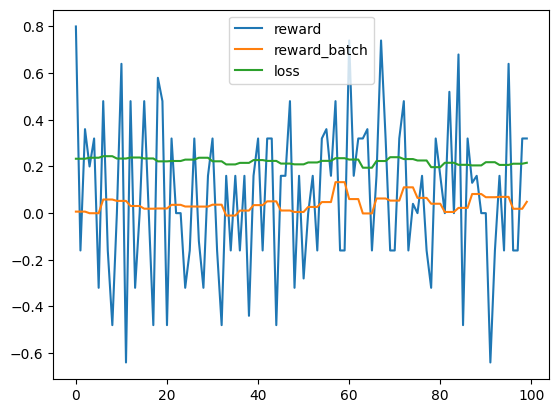

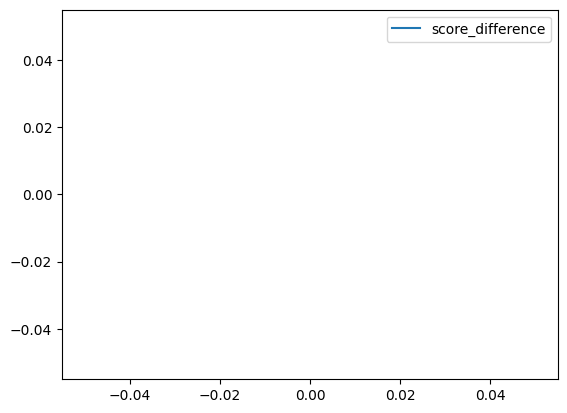

  0%|          | 100/100000 [00:25<6:59:16,  3.97it/s]


AttributeError: 'DQN' object has no attribute 'expected_info'

In [ ]:
def train():
    model = DQN(
        n_masks=N_MASKS,
        n_actions=N_ACTIONS,
        n_predators=N_PREDATORS,
        map_size=MAP_SIZE,
        device=DEVICE,
        config=cfg
    ).to(DEVICE).train()

    logger = Logger(cfg)

    # INITIAL STEPS
    env = get_env(n_predators=N_PREDATORS, difficulty=-1, step_limit=cfg.max_steps_for_episode)
    state, info = env.reset()    
    processed_state = preprocess(state, info)
    r = Reward(N_PREDATORS, cfg.reward_params)
    for _ in trange(cfg.initial_steps):
        actions = model.get_actions(processed_state, random=True)
        next_state, done, next_info = env.step(actions)
        next_processed_state = preprocess(next_state, next_info)
        reward = r(processed_state, info, next_processed_state, next_info)
        model.consume_transition(processed_state, actions, next_processed_state, reward, done)
        state, info = (next_state, next_info) if not done else env.reset()        
        processed_state = preprocess(state, info)
        

    # with open(f'pre_calc_buffer_simple_10000.pkl', 'wb') as handle:
    #     pickle.dump(model.buffer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # TRAINING
    # with open('pre_calc_buffer_simple_10000.pkl', 'rb') as handle:
    #     model.buffer = pickle.load(handle)

    env = get_env(n_predators=N_PREDATORS, difficulty=-1, step_limit=cfg.max_steps_for_episode)
    state, info = env.reset()
    processed_state = preprocess(state, info)
    r = Reward(N_PREDATORS, cfg.reward_params)
    score_difference = None

    try:
        for _ in trange(cfg.steps):
            # ========== step ==========================================================
            eps_threshold = cfg.eps_end + (cfg.eps_start - cfg.eps_end) * \
                math.exp(-1. * model.steps_done / cfg.eps_decay)
            actions = model.get_actions(processed_state, random=(random.random() < eps_threshold))
            next_state, done, next_info = env.step(actions)
            next_processed_state = preprocess(next_state, next_info)
            reward = r(processed_state, info, next_processed_state, next_info)
            model.consume_transition(processed_state, actions, next_processed_state, reward, done)

            if done:
                # not just reset in oreder to implement changes of map
                # env = get_env(n_predators=N_PREDATORS, difficulty=model.steps_done/cfg.steps,
                #               step_limit=cfg.max_steps_for_episode) # CHANGE !!!!!!!!!
                env = get_env(n_predators=N_PREDATORS, difficulty=-1,
                step_limit=cfg.max_steps_for_episode) # CHANGE !!!!!!!!!
                state, info = env.reset()
            else:
                state, info = next_state, next_info

            processed_state = preprocess(state, info)

            # ========== updates =======================================================
            if model.steps_done % cfg.steps_per_update == 0:
                reward_batch, loss = model.update_policy_network()

            model.soft_update_target_network()  # each step

            if model.steps_done % cfg.steps_per_paint == 0 and model.steps_done > 0:
                paint(logger, [['reward', 'reward_batch', 'loss'], ['score_difference']])

            if model.steps_done % cfg.steps_per_eval == 0 and model.steps_done > 0:
                os.makedirs(logger.curr_subfolder_path + '/gifs', exist_ok=True)
                path = f'{logger.curr_subfolder_path}/gifs/{model.steps_done}_steps.gif'
                simulate_episode(model, model.steps_done/cfg.steps, N_PREDATORS, cfg, path, render_gif=True)
                score_difference = evaluate(model, N_PREDATORS, cfg)


            model.steps_done += 1

            # ========== logs ==========================================================
            logger.add('eps', eps_threshold)
            logger.add('reward', reward.mean())
            logger.add('reward_batch', reward_batch)
            logger.add('loss', loss)
            logger.add('score_difference', score_difference)

    except KeyboardInterrupt:
        print('Training interrupted')

    # finally:
    #     logger.save()
    #     model.save(logger.curr_subfolder_path + f'/model_steps_{model.steps_done}.pt')
    #     return model


model = train()

# TODO

0. зафорсить оптимальные действия в инишал буффер ??
0. добавить шедулер ??
6. если заработает бейзлайн, подумать как добавить возм-ть выучить "бфс"

# заметки



In [ ]:
model = DQN(
    n_masks=N_MASKS,
    n_actions=N_ACTIONS,
    n_predators=N_PREDATORS,
    map_size=MAP_SIZE,
    device=DEVICE,
    config=cfg
).to(DEVICE).train()

with open('pre_calculated_buffer_10000.pkl', 'rb') as handle:
    buffer = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'pre_calculated_buffer_10000.pkl'

In [ ]:
        #     rews.append(reward)
        # rews = np.stack(rews)
        # sft = softmax(rews)
        # actions = []
        # for i in range(5):
        #     action = np.random.choice(np.arange(4), p=sft[:, i]) + 1
        #     actions.append(action)
        # return actions